# Vision Transformers for Malaria Detection

This set of notebooks was built from the code provided by in Sovit Ranjan Rath's post here: https://debuggercafe.com/malaria-classification-with-vision-transformer-and-pytorch/

Much of the text quotes from the blog post.

![Cover image from Sovit's post on Debugger Cafe showing sample images of malaria and the attention maps](images/Malaria-Classification-with-Vision-Transformer-and-PyTorch-e1693359747566.png)

> In this article, we are going to carry out malaria classification with vision transformer and PyTorch. While malaria can be detected from blood samples and laboratory testing, we can speed up the process using deep learning and computer vision. Malaria can be life-threatening if not diagnosed on time. With deep learning, we can train an image classification model that can recognize whether a zoomed-in blood-smear sample has malaria parasites or not. For this malaria classification model, we will employ a vision transformer and the PyTorch framework.
> 
> **Note that 5 plasmodium species cause malaria in humans.** However, in this article, we will classify whether a blood sample contains a malarial parasite or not. We will not distinguish between the different species of Plasmodium. This is just getting started with malaria classification with vision transformer, so, we keep the problem statement simple.



In [13]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
from tools.utils.dataloaders import get_dataloaders
from tools.utils.general import (
    SaveBestModel, 
    save_model,
    set_training_dir,
    save_loss_plot,
    save_accuracy_plot
)
from tools.utils.load_model import create_model
from tools.utils.logging import set_log, log
from vision_transformers.models import vit

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [17]:
model = 'vit_ti_p16_224'
data_dir = '/lustre/fs0/bsc4892/share/Malaria_dataset/train'
epochs = 5 
lr = 0.0005
batch = 128 
name = 'vit_ti_5e_128b'
valid_split = 0.15

In [15]:
# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    log('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    log('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


## The ViT Tiny Model

> For training on the malaria classification dataset, we will use the ViT Tiny model. In the library, we refer to this model as vit_ti_p16_224. The naming convention lets us know that the ViT Tiny model converts each 224×224 image into 16×16 patches. As the dataset is quite simple, we do not need to use any larger model right away. The model has been pretrained on the ImageNet weights.
>
> For 2 classes, the final model contains roughly 5.5 million parameters. Compared to the base ViT, the ViT Tiny model has a smaller embedding layer. It contains a 192-dimensional embedding instead of a 768-dimensional embedding.


In [18]:
OUT_DIR = set_training_dir(name)
set_log(OUT_DIR)

dataset_train, \
    dataset_valid, \
    train_loader, \
    valid_loader, dataset_classes = get_dataloaders(
        data_dir=data_dir,
        valid_split=valid_split,
        batch_size=batch,
        image_size=224
    )
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Classes: {dataset_classes}")

# Load the training and validation data loaders.

# Learning_parameters. 
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

# Load the model.
build_model = create_model[model]
model = build_model(
    image_size=224, num_classes=len(dataset_classes), pretrained=True
)
_ = model.to(device)
print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Loss function.
criterion = nn.CrossEntropyLoss()

# Initialize SaveBestModel class
save_best_model = SaveBestModel()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# if torch.__version__ >= '2.0.0':
#     model = torch.compile(model)



[INFO]: Number of training images: 18595
[INFO]: Number of validation images: 3281
[INFO]: Classes: ['parasitized', 'uninfected']
Computation device: cuda
Learning rate: 0.0005
Epochs to train for: 5

Loading vit_ti_p16_224 pretrained weights
Loading timm weights
ViT(
  (patches): CreatePatches(
    (patch): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-11): 12 x ModuleList(
        (0): Normalization(
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (out): Sequential(
              (0): Linear(in_features=192, out_features=192, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): Normalization(
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (fn):

Training
Training
Training
Training
Training
Training


[INFO]: Epoch 1 of 5


100%|██████████| 146/146 [00:24<00:00,  5.91it/s]
Validation
Validation
Validation
Validation
Validation
Validation
100%|██████████| 26/26 [00:04<00:00,  5.72it/s]



LOWEST VALIDATION LOSS: 0.11124367295549466

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...


Training
Training
Training
Training
Training
Training


Training loss: 0.144, training acc: 94.966
Validation loss: 0.111, validation acc: 96.282
--------------------------------------------------
[INFO]: Epoch 2 of 5


100%|██████████| 146/146 [00:23<00:00,  6.14it/s]
Validation
Validation
Validation
Validation
Validation
Validation
100%|██████████| 26/26 [00:04<00:00,  5.91it/s]



LOWEST VALIDATION LOSS: 0.10360979446424888

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...


Training
Training
Training
Training
Training
Training


Training loss: 0.098, training acc: 96.623
Validation loss: 0.104, validation acc: 96.282
--------------------------------------------------
[INFO]: Epoch 3 of 5


100%|██████████| 146/146 [00:23<00:00,  6.09it/s]
Validation
Validation
Validation
Validation
Validation
Validation
100%|██████████| 26/26 [00:04<00:00,  5.95it/s]



LOWEST VALIDATION LOSS: 0.09838134293945935

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...


Training
Training
Training
Training
Training
Training


Training loss: 0.086, training acc: 96.945
Validation loss: 0.098, validation acc: 96.464
--------------------------------------------------
[INFO]: Epoch 4 of 5


100%|██████████| 146/146 [00:23<00:00,  6.13it/s]
Validation
Validation
Validation
Validation
Validation
Validation
100%|██████████| 26/26 [00:04<00:00,  6.10it/s]



LOWEST VALIDATION LOSS: 0.0897803412607083

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...


Training
Training
Training
Training
Training
Training


Training loss: 0.078, training acc: 97.279
Validation loss: 0.090, validation acc: 96.556
--------------------------------------------------
[INFO]: Epoch 5 of 5


100%|██████████| 146/146 [00:23<00:00,  6.20it/s]
Validation
Validation
Validation
Validation
Validation
Validation
100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


SAVING PLOTS COMPLETE...
Training loss: 0.068, training acc: 97.462
Validation loss: 0.094, validation acc: 96.251
--------------------------------------------------
TRAINING COMPLETE


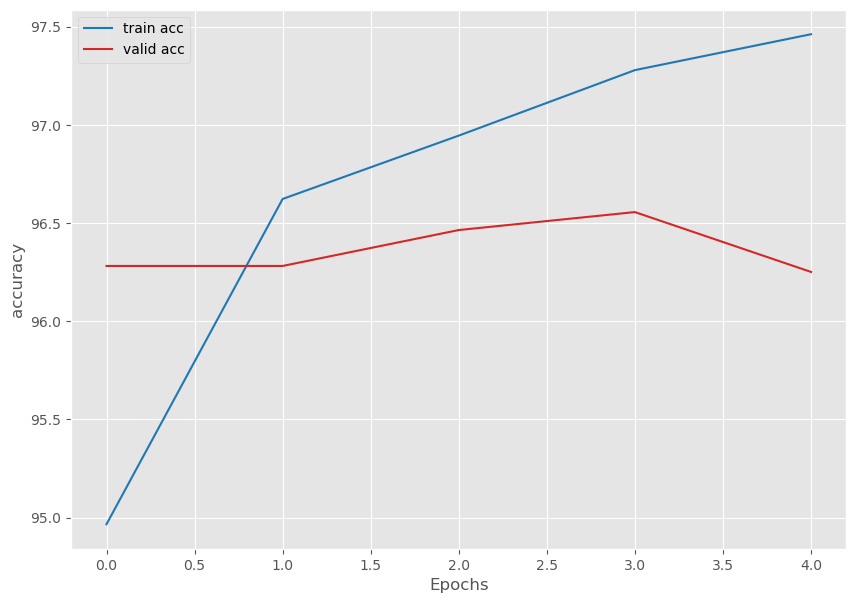

In [19]:
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                criterion, dataset_classes)
    # Save the best model till now.
    save_best_model(
        model, valid_epoch_loss, epoch, OUT_DIR
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    # Save loss and accuracy plots.
    save_loss_plot(OUT_DIR, train_loss, valid_loss)
    save_accuracy_plot(OUT_DIR, train_acc, valid_acc)
    save_model(OUT_DIR, epoch, model, optimizer, criterion)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
print('TRAINING COMPLETE')